In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
def load_and_process_csv(path, term_in_file='PMTrans'):
    # List to hold individual DataFrames with hierarchical indices
    dfs = []
    is_PMNN = term_in_file in ['h4q', 'tbqq']  # Check for PMNN cases
    is_PMNN_test = term_in_file in ['h4q_test', 'tbqq_test']  # Check for test variants

    # List all CSV files in the given directory
    for filename in os.listdir(path):
        
        # Only process files ending with '.csv' and matching the term_in_file conditions
        if filename.endswith('.csv') and term_in_file in filename:
            # Ensure that '_test' is not in filename when term_in_file is 'h4q' or 'tbqq'
            if (is_PMNN and '_test' not in filename) or is_PMNN_test or (term_in_file not in ['h4q', 'tbqq']):
                # Split the filename by '_'
                temp_filename = filename
                if 'h4q_test' in filename:
                    temp_filename = filename.replace('h4q_test', 'h4q-test')
                elif 'tbqq_test' in filename:
                    temp_filename = filename.replace('tbqq_test', 'tbqq-test')

                parts = temp_filename.split('_')
                
                # print(parts)
                
                if parts[3] == 'PMTrans':
                    start_dim = 4
                else:
                    start_dim = 3
#                 if len(parts) == 9 or len(parts) == 11:
#                     start_dim = 4
#                 else:
#                     start_dim = 3

                if is_PMNN or is_PMNN_test:
                    start_dim += 1

                # Extract particle and jet information
                particle_geom = parts[start_dim]
                particle_dim = int(parts[start_dim + 1])
                if 'x' in particle_geom:
                    particle_dim *= 2

                if not (is_PMNN or is_PMNN_test):
                    jet_geom = parts[start_dim + 2]
                    jet_dim = int(parts[start_dim + 3])
                    if 'x' in jet_geom:
                        jet_dim *= 2

                # Load the CSV into a DataFrame
                df = pd.read_csv(os.path.join(path, filename))

                # Create a MultiIndex for this DataFrame
                if is_PMNN or is_PMNN_test:
                    index_tuples = [(particle_geom, particle_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim'])
                else:
                    index_tuples = [(particle_geom, particle_dim, jet_geom, jet_dim)] * len(df)
                    index = pd.MultiIndex.from_tuples(index_tuples, names=['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

                # Assign the MultiIndex to the DataFrame
                df.index = index
                df['name'] = filename

                # Append the DataFrame to the list
                dfs.append(df)
    
    # Concatenate all DataFrames into one, maintaining the hierarchical index
    combined_df = pd.concat(dfs)
    
    return combined_df


In [3]:
import matplotlib.pyplot as plt

def correct_string_to_latex(s):
    # Split the string by underscores to handle multiple terms
    terms = s.split('x')
    temp_str = ''
    # Transform each term into LaTeX format with superscripts
    latex_terms = []
    
    i = 0
    while i < len(terms):
        
        base = terms[i]
        latex_term = f"\\mathbb{{{base.capitalize()}}}"
        i = i + 1
        temp_str = temp_str + latex_term
        if len(terms) > i:
            temp_str = temp_str + ' \\times '
    
    # Join terms with the LaTeX product symbol if there are multiple terms
    latex_string = ' \\times '.join(latex_terms)
    
    return f"${temp_str}$"

def plot_highest_accuracies(df, 
                            variable_to_vary, 
                            metric_column='acc', 
                            filter_values=None, 
                            acc_range = None,
                            title = None,
                            PMNN = False,
                            plot_trans_params = False,
                            hide_fig = False,
                            filter_name = ['none']):
    # Identify the columns that will remain constant
    leg_title = ''
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']
        
    remaining_columns.remove(variable_to_vary)
    
    colormap1 = plt.get_cmap('Set2', 6)  # 'viridis' is an example
    colormap2 = plt.get_cmap('Set1', 6)
    color_dict = {
        'R': colormap1(0),    # First color
        'RxH': colormap1(1),  # Second color
        'RxS': colormap1(2),
        'H': colormap1(3),
        'S': colormap1(4),
        'HxS': colormap1(5),
        'RxR': colormap2(0),
        'HxH': colormap2(1),
        'SxS': colormap2(2)
    }

    if filter_values:
        indexer = pd.IndexSlice
        for col, val in filter_values.items():
            if val == 'match' and col in ['particle_geom', 'jet_geom']:
                # Select rows where 'particle_geom' and 'jet_geom' are the same
                df = df[df.index.get_level_values('particle_geom') == df.index.get_level_values('jet_geom')]
            else:
                # Regular filtering based on the provided value
                df = df[df.index.get_level_values(col) == val]



    # Group by the remaining columns and the variable_to_vary
    grouped = df.groupby(remaining_columns)
    out_data = {}
    # Plot each group
    plt.figure(figsize=(10, 8),facecolor='white')
    for name, group in grouped:
            
            if PMNN: 
                if name in filter_name:
                    continue
                raw_name = name
                name = correct_string_to_latex(name)
                
                leg_title = 'Particle-Level Geom.'
            else:
                if 'particle_geom' in filter_values:
                    if name[-1] in filter_name:
                        continue
                    raw_name = name[-1]
                    name = correct_string_to_latex(name[-1]) 
                    
                    leg_title = 'Jet-Level Geom.'
                else:
                    if name[0] in filter_name:
                        continue
                    raw_name = name[0]
                    name = correct_string_to_latex(name[0]) 
                    leg_title = 'Particle-Level Geom.'

            # Find the maximum accuracy for each unique value in the variable_to_vary column
            if PMNN:
                max_values = group.groupby(['name', variable_to_vary])[metric_column].max()
                max_values = max_values.drop(columns=['name'])
#                 max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.nlargest(2).mean())
                max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.max())
                max_std = max_values.groupby(variable_to_vary).apply(lambda x: x.std())
                absolute_max_accuracy = group.groupby(variable_to_vary)[metric_column].max()
            else:
                max_values = group.groupby(['name', variable_to_vary])[metric_column].max()
                max_values = max_values.drop(columns=['name'])
                max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.max())
                absolute_max_accuracy = group.groupby(variable_to_vary)[metric_column].max()


            # Plot the data
            if plot_trans_params:
                PM_model_sizes ={ 
                        '32': 23.85,
                        '48': 46.03,
                        '64': 76.48,
                        '96': 162.14,
                        '128': 280.82,
                        '160': 466.28,
                        '176': 560.69,
                        '200': 718.75,
                        '240': 1040,
                        '192': 1010,
                        '256': 1090}
                M_model_sizes ={
                        '16': 14.28,
                        '32': 41.03,
                        '48':84.48,
                        '64': 144.64 ,
                        '96': 315.06,
                        '128': 552.3, 
                        '144': 695.98,
                        '160': 856.36,
                        '256': 2170}
                model_dims = max_accuracy.index

                if 'times' in name:
                    model_params = [PM_model_sizes[str(m)] for m in model_dims]
                else:
                    model_params = [M_model_sizes[str(m)] for m in model_dims]
                
                plt.plot(model_params, 100*absolute_max_accuracy.values,linestyle = '--', color = color_dict[raw_name])
              

            else:
                plt.plot(max_accuracy.index, 100*absolute_max_accuracy.values, color = color_dict[raw_name],
                label=f"{name}",marker='o')
                
                
           

                out_data[name]= [max_accuracy.index, 100*max_accuracy.values]
            
    if plot_trans_params:
        y_label = 'Model Parameteters (k)'
    else:    
        if variable_to_vary == 'particle_dim':
            y_label = 'Particle-Level Dim'
        else:
            y_label = 'Jet-Level Dim'

    plt.xlabel(y_label)
    plt.ylabel('Accuracy (%)')
        
    plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
    plt.grid(True)
    plt.tight_layout()
    if PMNN:
        plt.xscale('log', base=2)
    if acc_range is not None:
        plt.ylim(*acc_range)
    if not hide_fig:
        plt.show()  # Only show if hide_fig is False
    else:
        plt.close()
    return out_data

In [4]:
path = 'performance_summaries/JetClass/JetClass_performance_summary_part_lvl_redo'

df = load_and_process_csv(path, term_in_file = 'PM')


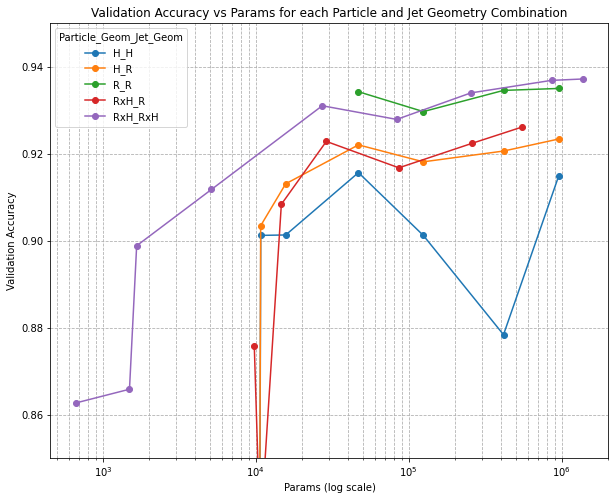

In [19]:
path = 'performance_summaries/Top/TopLandscape_performance_summary_top_paper_redo'

df = load_and_process_csv(path, term_in_file = 'PM')
remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']

geom_cols = ['particle_geom', 'jet_geom']
g = df.groupby(remaining_columns).apply(lambda x: x.ffill().bfill().iloc[0])
params = g['params']

# Reset the index and add the indices back as columns
df_reset = df.reset_index()

# Group by the specified columns and select the row with the highest 'val_acc' for each group
grouped_idx = df_reset.groupby(remaining_columns)['val_acc'].idxmax()
grouped = df_reset.loc[grouped_idx]

# Drop the added index column
grouped = grouped.set_index(remaining_columns)
grouped['params'] = params


# Function to convert params to float
def convert_params(param):
    if isinstance(param, str):
        if 'k' in param:
            return float(param.replace('k', '')) * 1e3
        elif 'M' in param:
            return float(param.replace('M', '')) * 1e6
    return float(param)

# Apply the conversion function to the params column
grouped['params'] = grouped['params'].apply(convert_params)

# Group by particle_geom and jet_geom
grouped_by_geom = grouped.groupby(['particle_geom', 'jet_geom'])

# Plot each group
plt.figure(figsize=(10, 8), facecolor='white')
for (particle_geom, jet_geom), group in grouped_by_geom:
    plt.plot(group['params'], group['val_acc'], marker='o', label=f'{particle_geom}_{jet_geom}')

plt.xlabel('Params (log scale)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Params for each Particle and Jet Geometry Combination')
plt.xscale('log')
plt.ylim(0.85,0.95)
plt.legend(title='Particle_Geom_Jet_Geom')
plt.grid(True, which="both", ls="--")
plt.show()


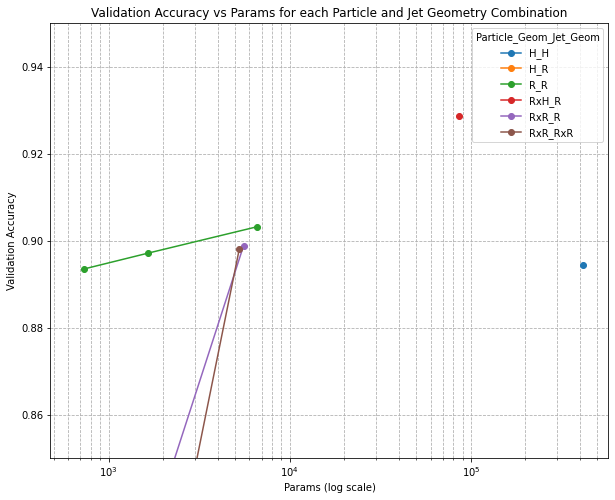

In [20]:
path = 'TopLandscape_performance_summary_top_paper_redo'


df = load_and_process_csv(path, term_in_file = 'PM')
remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']

geom_cols = ['particle_geom', 'jet_geom']
g = df.groupby(remaining_columns).apply(lambda x: x.ffill().bfill().iloc[0])
params = g['params']

# Reset the index and add the indices back as columns
df_reset = df.reset_index()

# Group by the specified columns and select the row with the highest 'val_acc' for each group
grouped_idx = df_reset.groupby(remaining_columns)['val_acc'].idxmax()
grouped = df_reset.loc[grouped_idx]

# Drop the added index column
grouped = grouped.set_index(remaining_columns)
grouped['params'] = params

# Function to convert params to float
def convert_params(param):
    if isinstance(param, str):
        if 'k' in param:
            return float(param.replace('k', '')) * 1e3
        elif 'M' in param:
            return float(param.replace('M', '')) * 1e6
    return float(param)

# Apply the conversion function to the params column
grouped['params'] = grouped['params'].apply(convert_params)

# Group by particle_geom and jet_geom
grouped_by_geom = grouped.groupby(['particle_geom', 'jet_geom'])

# Plot each group
plt.figure(figsize=(10, 8), facecolor='white')
for (particle_geom, jet_geom), group in grouped_by_geom:
    plt.plot(group['params'], group['val_acc'], marker='o', label=f'{particle_geom}_{jet_geom}')

plt.xlabel('Params (log scale)')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Params for each Particle and Jet Geometry Combination')
plt.xscale('log')
plt.ylim(0.85,0.95)
plt.legend(title='Particle_Geom_Jet_Geom')
plt.grid(True, which="both", ls="--")
plt.show()

ValueError: Grouper and axis must be same length

<Figure size 720x576 with 0 Axes>

In [ ]:

def plot_simple_highest_acc(df, 
                            variable_to_vary, 
                            metric_column='acc', 
                            acc_range = None,
                            title = None,
                            PMNN = False,
                            plot_trans_params = False,
                            hide_fig = False,
                            filter_name = ['none']):
    # Identify the columns that will remain constant
    leg_title = ''
    if not PMNN:
        remaining_columns = ['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim']
    else:
        remaining_columns = ['particle_geom', 'particle_dim']
        
    remaining_columns.remove(variable_to_vary)
    
    colormap1 = plt.get_cmap('Set2', 6)  # 'viridis' is an example
    colormap2 = plt.get_cmap('Set1', 6)
    color_dict = {
        'R': colormap1(0),    # First color
        'RxH': colormap1(1),  # Second color
        'RxS': colormap1(2),
        'H': colormap1(3),
        'S': colormap1(4),
        'HxS': colormap1(5),
        'RxR': colormap2(0),
        'HxH': colormap2(1),
        'SxS': colormap2(2)
    }


    # Group by the remaining columns and the variable_to_vary
    grouped = df.groupby(remaining_columns)
    out_data = {}
    # Plot each group
    plt.figure(figsize=(10, 8),facecolor='white')
    for name, group in grouped:
            
            if PMNN: 
                if name in filter_name:
                    continue
                raw_name = name
                name = correct_string_to_latex(name)
                
                leg_title = 'Particle-Level Geom.'
            else:
                if 'particle_geom' in filter_values:
                    if name[-1] in filter_name:
                        continue
                    raw_name = name[-1]
                    name = correct_string_to_latex(name[-1]) 
                    leg_title = 'Jet-Level Geom.'
                else:
                   
                    name = f'({correct_string_to_latex(name[0])},{ correct_string_to_latex(name[-1])})'
                    leg_title = 'PM-Transformer Geometries'

            # Find the maximum accuracy for each unique value in the variable_to_vary column
            if PMNN:
                max_values = group.groupby(['name', variable_to_vary])[metric_column].max()
                max_values = max_values.drop(columns=['name'])
                max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.max())
            else:
                max_values = group.groupby(['name', variable_to_vary])[metric_column].max()
                max_values = max_values.drop(columns=['name'])
                max_accuracy = max_values.groupby(variable_to_vary).apply(lambda x: x.max())

            plt.plot(max_accuracy.index, 100*absolute_max_accuracy.values, color = color_dict[raw_name],
            label=f"{name}",marker='o')

            out_data[name]= [max_accuracy.index, 100*max_accuracy.values]
            
    if plot_trans_params:
        y_label = 'Model Parameteters (k)'
    else:    
        if variable_to_vary == 'particle_dim':
            y_label = 'Particle-Level Dim'
        else:
            y_label = 'Jet-Level Dim'

    plt.xlabel(y_label)
    plt.ylabel('Accuracy (%)')
        
    plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
    plt.grid(True)
    plt.tight_layout()
    if PMNN:
        plt.xscale('log', base=2)
    if acc_range is not None:
        plt.ylim(*acc_range)
    if not hide_fig:
        plt.show()  # Only show if hide_fig is False
    else:
        plt.close()
    return out_data

In [6]:
path = 'JetClass_performance_summary_part_lvl_redo'

combined_df = load_and_process_csv(path, term_in_file = 'PM')


In [13]:
# path = 'JetClass_performance_summary_PMNN_h4q_neurips_for_paper'
path = 'JetClass_performance_summary_PMNN_h4q_neurips_for_paper_new_data'

combined_df = load_and_process_csv(path, term_in_file = 'PM')
# plot_highest_accuracies(combined_df,title = 'H4q tagging', 
#                         variable_to_vary='particle_dim',
#                         PMNN = True,
#                         metric_column='val_acc',
#                         plot_best = True,
# #                         acc_range = [80.5,87],
#                         filter_name = ['S','SxS']
#                         )


# acc_range = [80,90]

ValueError: invalid literal for int() with base 10: 'HxH'

In [9]:
combined_df


NameError: name 'combined_df' is not defined

In [7]:
# path = 'JetClass_performance_summary_PMNN_h4q_neurips_for_paper'
path = 'JetClass_performance_summary_part_lvl_redo'


combined_df = load_and_process_csv(path, term_in_file = 'h4q')
plot_highest_accuracies(combined_df,title = 'H4q tagging', 
                        variable_to_vary='particle_dim',
                        PMNN = False,metric_column='val_acc',
                        plot_best = True,
#                         acc_range = [80.5,87],
                        filter_name = ['S','SxS']
                        )


# acc_range = [80,90]

ValueError: No objects to concatenate

In [1]:
path = 'TopLandscape_performance_summary_top_paper_redo'

combined_df = load_and_process_csv(path, term_in_file = 'PM')
plot_highest_accuracies(combined_df,title = 'Tbqq tagging', 
                        variable_to_vary='particle_dim',
                        PMNN = True,metric_column='val_acc',
                        plot_best = True,
                        filter_name = ['HxS','S','SxS']
#                         acc_range = [83.5,87]
                        )

# acc_range = [80,90]

NameError: name 'load_and_process_csv' is not defined

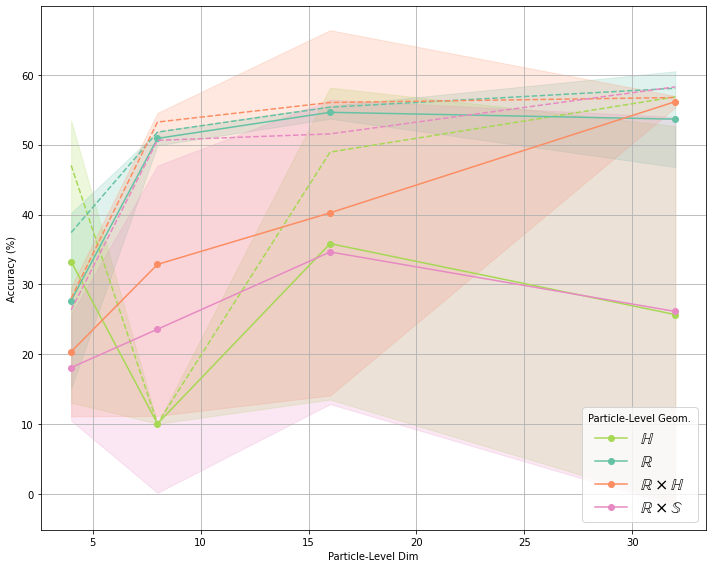

In [6]:
import pandas as pd
paths = [
         'JetClass_performance_summary_small_tuned_paper_v3_hidden']
all_df = [load_and_process_csv(path, term_in_file='final') for path in paths]
all_df = [df.reset_index() for df in all_df]
combined_df = pd.concat(all_df, ignore_index=True)
combined_df = combined_df.set_index(['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 4
}

for col, val in filter_values.items():
    if col in combined_df.index.names:
        combined_df = combined_df[combined_df.index.get_level_values(col) == val]

# Step 4: Call the plotting function
_= plot_highest_accuracies(combined_df, 
                           title='JetClass', 
                           variable_to_vary='particle_dim', 
                           filter_values=filter_values,
                           plot_trans_params = False,
                           filter_name = ['S','HxS'],
#                            acc_range = [67,73],
                           plot_best = True,
                           shaded_plot = True, 
#                            shade_by_range = True,
                           shade_by_std = True,
#                            top_3 = True, 
#                            middle_3 = True,
                           )

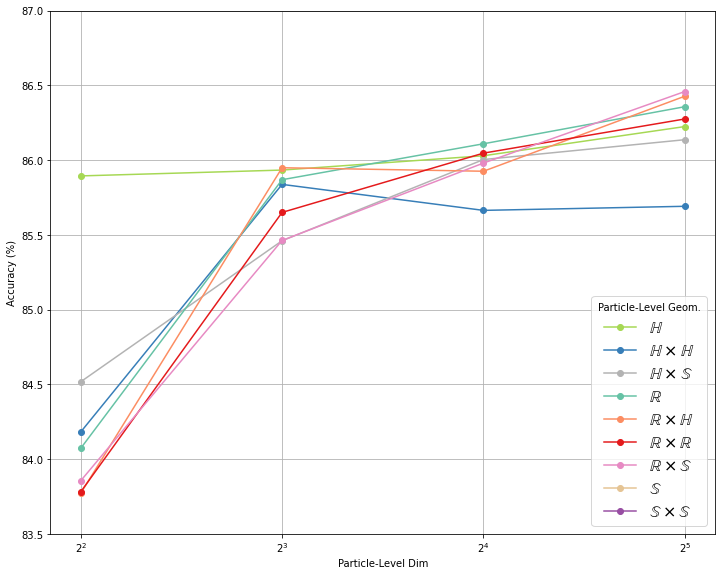

{'$\\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([85.89453125, 85.93359375, 86.02929688, 86.22460938])],
 '$\\mathbb{H} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.18164062, 85.83789062, 85.6640625 , 85.69140625])],
 '$\\mathbb{H} \\times \\mathbb{S}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.51757812, 85.4609375 , 86.00390625, 86.13671875])],
 '$\\mathbb{R}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([84.07226562, 85.86914062, 86.109375  , 86.35742188])],
 '$\\mathbb{R} \\times \\mathbb{H}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([83.77148438, 85.94921875, 85.92578125, 86.42773438])],
 '$\\mathbb{R} \\times \\mathbb{R}$': [Int64Index([4, 8, 16, 32], dtype='int64', name='particle_dim'),
  array([83.78125   , 85.65039062, 86.046875  , 86.27539062])],
 '$\\mathbb{R} \\times \\mathbb{S}$': 

In [244]:
path = 'JetClass_performance_summary_PMNN_h4q_neurips_more_runs'

combined_df = load_and_process_csv(path, term_in_file = 'h4q')
plot_highest_accuracies(combined_df,title = 'H4q tagging', 
                        variable_to_vary='particle_dim',
                        PMNN = True,metric_column='val_acc',
                        plot_best = True,
                        acc_range = [83.5,87]
                        )

# acc_range = [80,90]

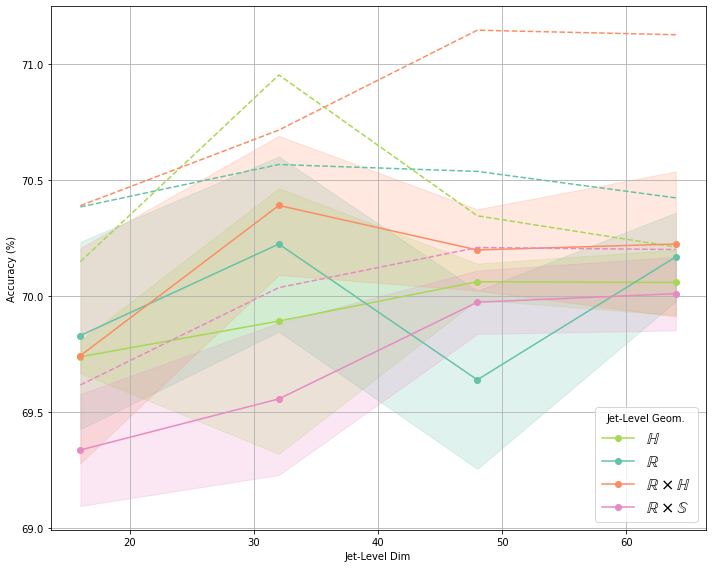

In [205]:
import pandas as pd

paths = [
         'JetClass_performance_summary_jet_lvl_v3_hidden']
all_df = [load_and_process_csv(path, term_in_file='final') for path in paths]
all_df = [df.reset_index() for df in all_df]
combined_df = pd.concat(all_df, ignore_index=True)
combined_df = combined_df.set_index(['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])
filter_values = {
    'particle_geom': 'R',
    'particle_dim': 32
}

for col, val in filter_values.items():
    if col in combined_df.index.names:
        combined_df = combined_df[combined_df.index.get_level_values(col) == val]

# Step 4: Call the plotting function
_= plot_highest_accuracies(combined_df, 
                           title='JetClass', 
                           variable_to_vary='jet_dim', 
                           filter_values=filter_values,
                           plot_trans_params = False,
                           filter_name = ['S','HxS'],
#                            acc_range = [67,73],
                           plot_best = True,
                           shaded_plot = True, 
#                            shade_by_range = True,
                           shade_by_std = True,
#                            top_3 = True, 
                           middle_3 = True,
                           )

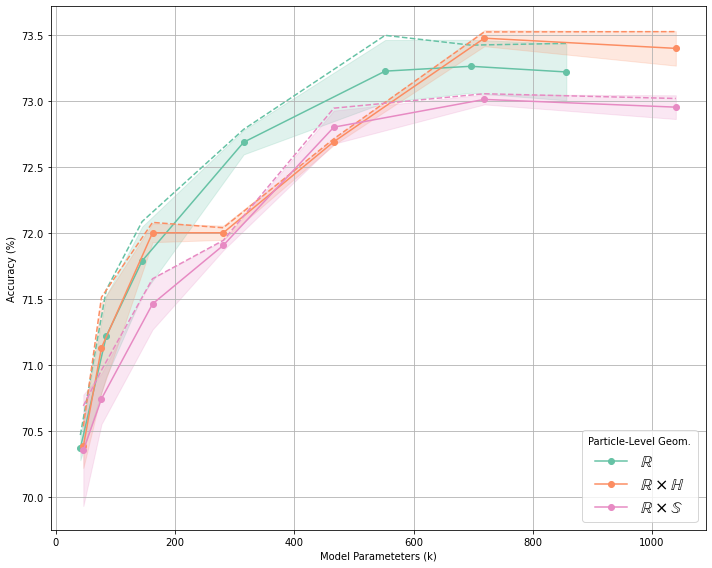

In [214]:
import pandas as pd

# paths = [
#          'JetClass_performance_summary_Euclidean_20_epochs',
#         'JetClass_performance_summary_tuned_paper_v3_hidden',
#         'JetClass_performance_summary_tuned_paper_v3_hidden_30_epochs',
#         'JetClass_performance_summary_Euclidean_30_epochs']

paths = [
         'JetClass_performance_summary_Euclidean_20_epochs',
        'JetClass_performance_summary_tuned_paper_v3_hidden',
        'JetClass_performance_summary_Euclidean_30_epochs_paper',
        'JetClass_performance_summary_tuned_paper_v3_hidden_30_epochs']

all_df = [load_and_process_csv(path, term_in_file='final') for path in paths]
all_df = [df.reset_index() for df in all_df]

combined_df = pd.concat(all_df, ignore_index=True)
combined_df = combined_df.set_index(['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}

for col, val in filter_values.items():
    if col in combined_df.index.names:
        combined_df = combined_df[combined_df.index.get_level_values(col) == val]

# Step 4: Call the plotting function
_= plot_highest_accuracies(combined_df, 
                           title='JetClass', 
                           variable_to_vary='particle_dim', 
                           filter_values={},
                           plot_trans_params = True,
                           plot_best = True,
                           shaded_plot = True, 
#                            shade_by_range = True,
                           shade_by_std = True,
                           top_3 = True, 
#                            middle_3 = True, 
                           filter_name = ['RxR','HxS'])

/tmp/ipykernel_2298455/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)


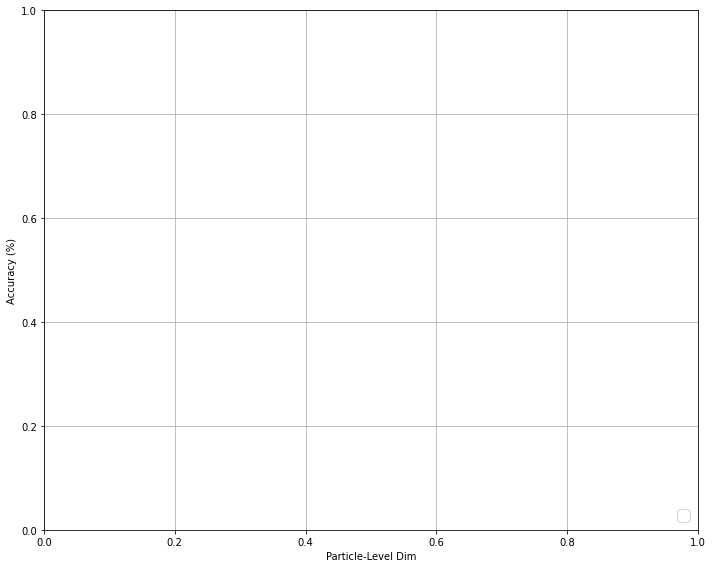

In [ ]:
import pandas as pd

# paths = [
#          'JetClass_performance_summary_Euclidean_20_epochs',
#         'JetClass_performance_summary_tuned_paper_v3_hidden',
#         'JetClass_performance_summary_tuned_paper_v3_hidden_30_epochs',
#         'JetClass_performance_summary_Euclidean_30_epochs']

paths = [
         'TopLandscape_performance_summary_top_paper_redo']

all_df = [load_and_process_csv(path, term_in_file='PM') for path in paths]
all_df = [df.reset_index() for df in all_df]

combined_df = pd.concat(all_df, ignore_index=True)
combined_df = combined_df.set_index(['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim'])

# filter_values = {
#     'jet_geom': 'R',
#     'jet_dim': 128
# }

for col, val in filter_values.items():
    if col in combined_df.index.names:
        combined_df = combined_df[combined_df.index.get_level_values(col) == val]

# Step 4: Call the plotting function
_= plot_highest_accuracies(combined_df, 
                           title='JetClass', 
                           metric_column = 'val_acc',
                           variable_to_vary='particle_dim', 
                           filter_values={},
#                            plot_trans_params = True,
                           plot_best = True,
                           shaded_plot = True, 
#                            shade_by_range = True,
                           shade_by_std = True,
                           top_3 = True, 
#                            middle_3 = True, 
                           filter_name = ['RxR','HxS'])

/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)


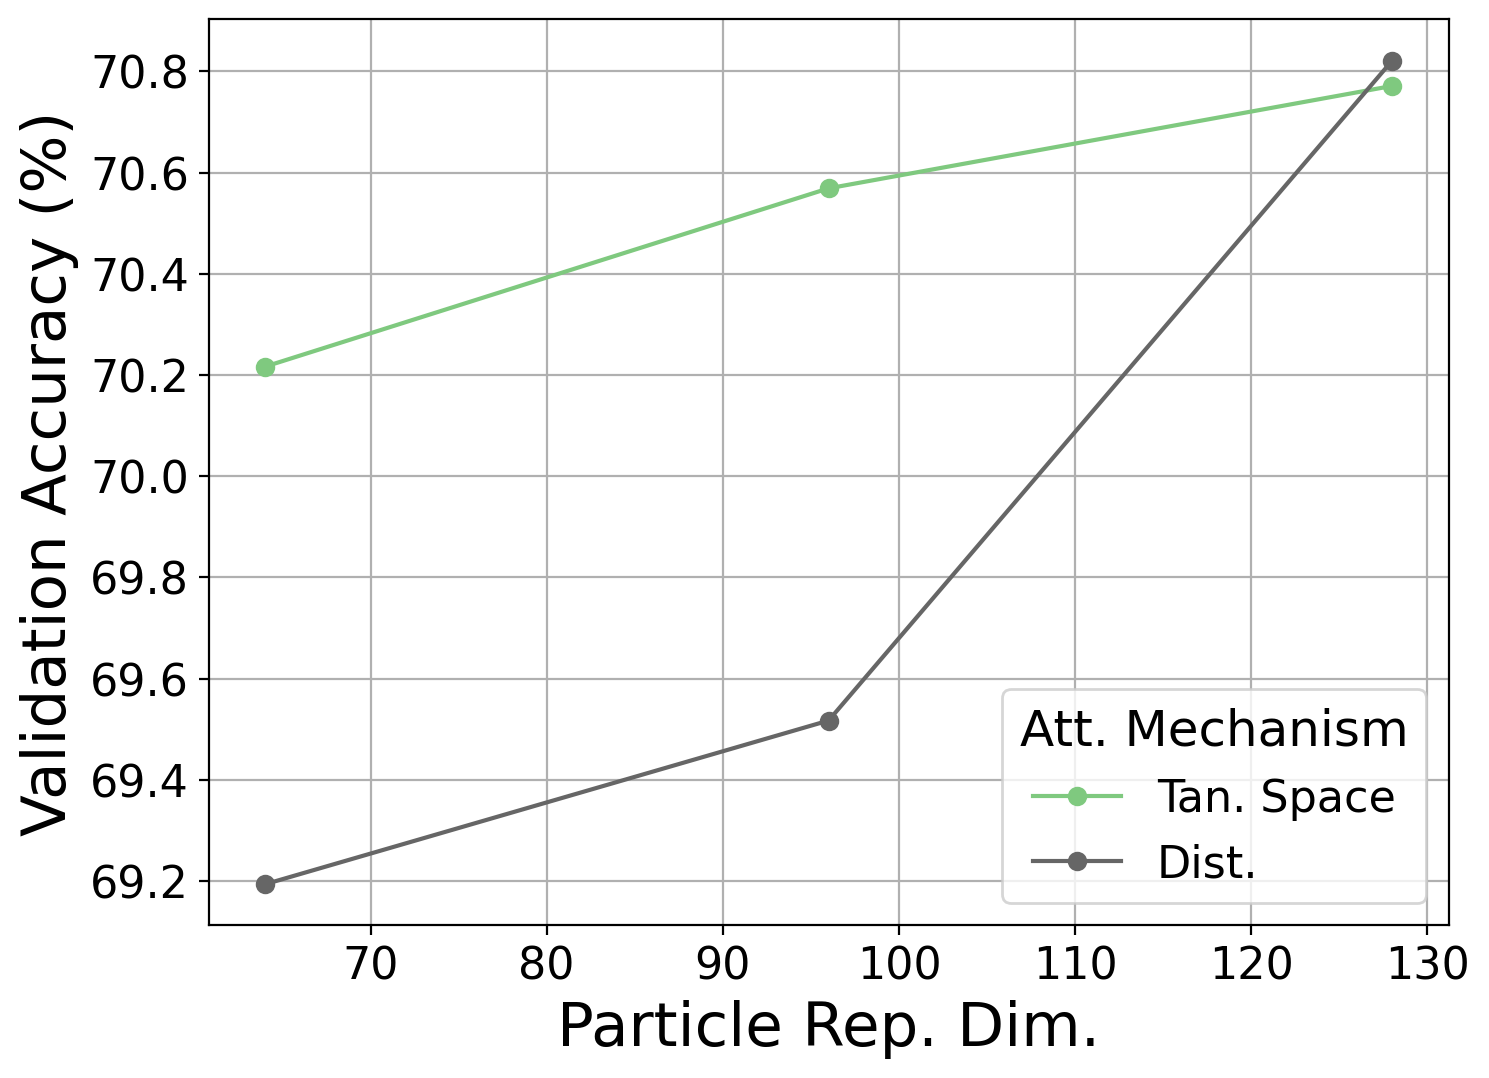

In [27]:
path = 'JetClass_performance_summary_paper_attention_comparison_dist'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)

dist_data = list(out_data.values())[0]

path = 'JetClass_performance_summary_paper_attention_comparison_tanspace'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)
tan_space_data = list(out_data.values())[0]

colormap = plt.get_cmap('Accent', 2)  # 'viridis' is an example


plt.figure(figsize=(8,6), dpi = 200)
plt.plot(tan_space_data[0],tan_space_data[1],label = 'Tan. Space',marker='o',color=colormap(0))
plt.plot(dist_data[0],dist_data[1], label = 'Dist.',marker='o', color = colormap(1))
plt.legend(title = 'Att. Mechanism',title_fontsize = 18,  fontsize=16, loc='lower right')
plt.tick_params(axis='x', labelsize=16)  # X-axis
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Validation Accuracy (%)', fontsize = 22)
plt.xlabel('Particle Rep. Dim.',fontsize = 22)
plt.grid(True)
plt.show()

/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)
/tmp/ipykernel_127344/2841560811.py:220: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f'{leg_title}', loc='lower right',fontsize = 16)


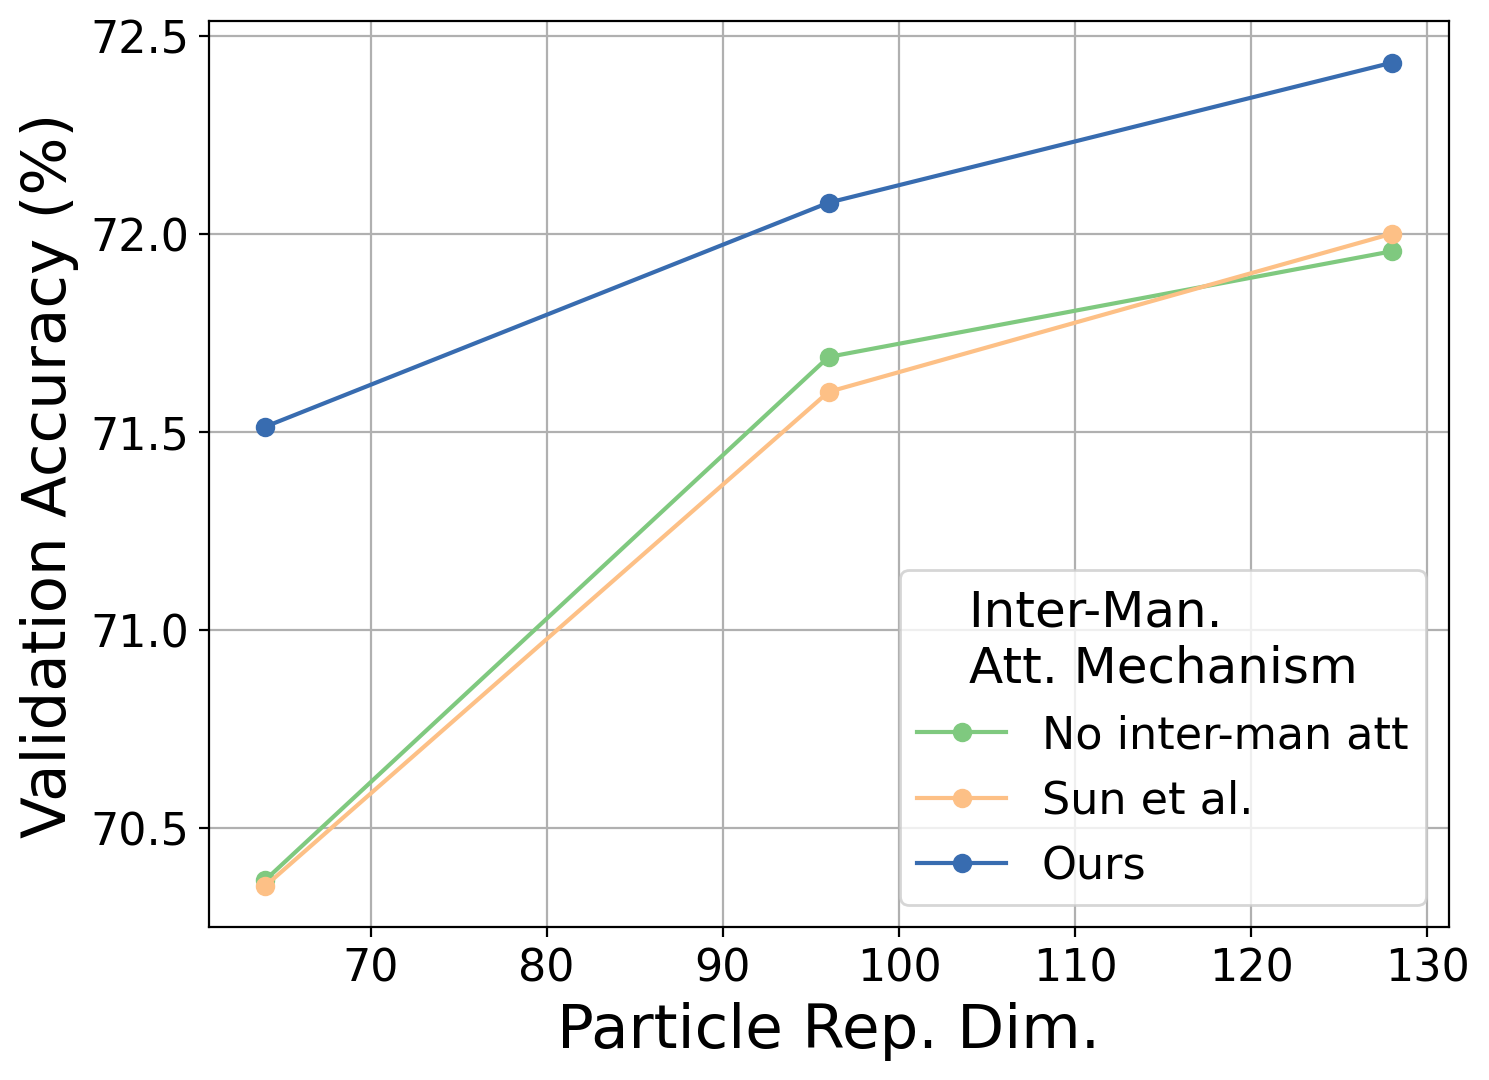

In [28]:
path = 'JetClass_performance_summary_paper_comparison_inter_man_none'

combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)

no_att_data = list(out_data.values())[0]

path = 'JetClass_performance_summary_paper_comparison_inter_man_v1'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)
v1_data = list(out_data.values())[0]

path = 'JetClass_performance_summary_tuned_paper_v3_hidden'
combined_df = load_and_process_csv(path, term_in_file = 'PMTrans')
filter_values = {
    'jet_geom': 'R',
    'jet_dim': 16
}
out_data = plot_highest_accuracies(combined_df,
                                   title = 'JetClass',
                                   variable_to_vary='particle_dim',
                                   filter_values=filter_values,
                                   hide_fig=True)
v2_data = list(out_data.values())[1]

colormap = plt.get_cmap('Accent', 5)  # 'viridis' is an example


plt.figure(figsize=(8,6),dpi =200)
plt.plot(no_att_data[0],no_att_data[1],label = 'No inter-man att',marker='o',c= colormap(0))
plt.plot(v1_data[0],v1_data[1],label = 'Sun et al. ',marker='o', c= colormap(1))
plt.plot(v2_data[0][1:-1],v2_data[1][1:-1],label = 'Ours',marker='o', c= colormap(2))
plt.legend(title = 'Inter-Man. \nAtt. Mechanism',title_fontsize = 18,  fontsize=16, loc='lower right')
plt.tick_params(axis='x', labelsize=16)  # X-axis
plt.tick_params(axis='y', labelsize=16)
plt.ylabel('Validation Accuracy (%)', fontsize = 22)
plt.xlabel('Particle Rep. Dim.',fontsize = 22)
plt.grid(True)
plt.show()

In [470]:
# Function to calculate metrics for each class
def calculate_metrics(y_true, y_scores, target_tprs=[0.5, 0.7, 0.99]):
    unique_classes = np.unique(y_true)
    aucs = {}
    accuracies = {}
    rejections = {tpr: {} for tpr in target_tprs}
    fprs = {}
    tprs = {}

    for class_label in unique_classes:
        binary_y_true = (y_true == class_label).astype(int)
        y_score = y_scores[:, class_label]

        if len(np.unique(binary_y_true)) < 2:
            aucs[class_label] = None
            accuracies[class_label] = None
            for tpr in target_tprs:
                rejections[tpr][class_label] = None
            fprs[class_label] = None
            tprs[class_label] = None
            continue

        fpr, tpr, thresholds = roc_curve(binary_y_true, y_score)
        auc = roc_auc_score(binary_y_true, y_score)
        accuracy = accuracy_score(binary_y_true, y_score >= 0.5)
        
        rejections_for_class = {}
        for tpr_value in target_tprs:
            if tpr_value in tpr:
                target_index = np.where(tpr >= tpr_value)[0][0]
                target_fpr = fpr[target_index]
                rejections_for_class[tpr_value] = 1 / target_fpr if target_fpr != 0 else np.inf
            else:
                rejections_for_class[tpr_value] = None
        
        aucs[class_label] = auc
        accuracies[class_label] = accuracy
        for tpr in target_tprs:
            rejections[tpr][class_label] = rejections_for_class[tpr]
        
        # Check if fpr and tpr are lists before converting them
        fprs[class_label] = fpr.tolist() if isinstance(fpr, (list, np.ndarray)) else []
        tprs[class_label] = tpr.tolist() if isinstance(tpr, (list, np.ndarray)) else []

    return aucs, accuracies, rejections, fprs, tprs


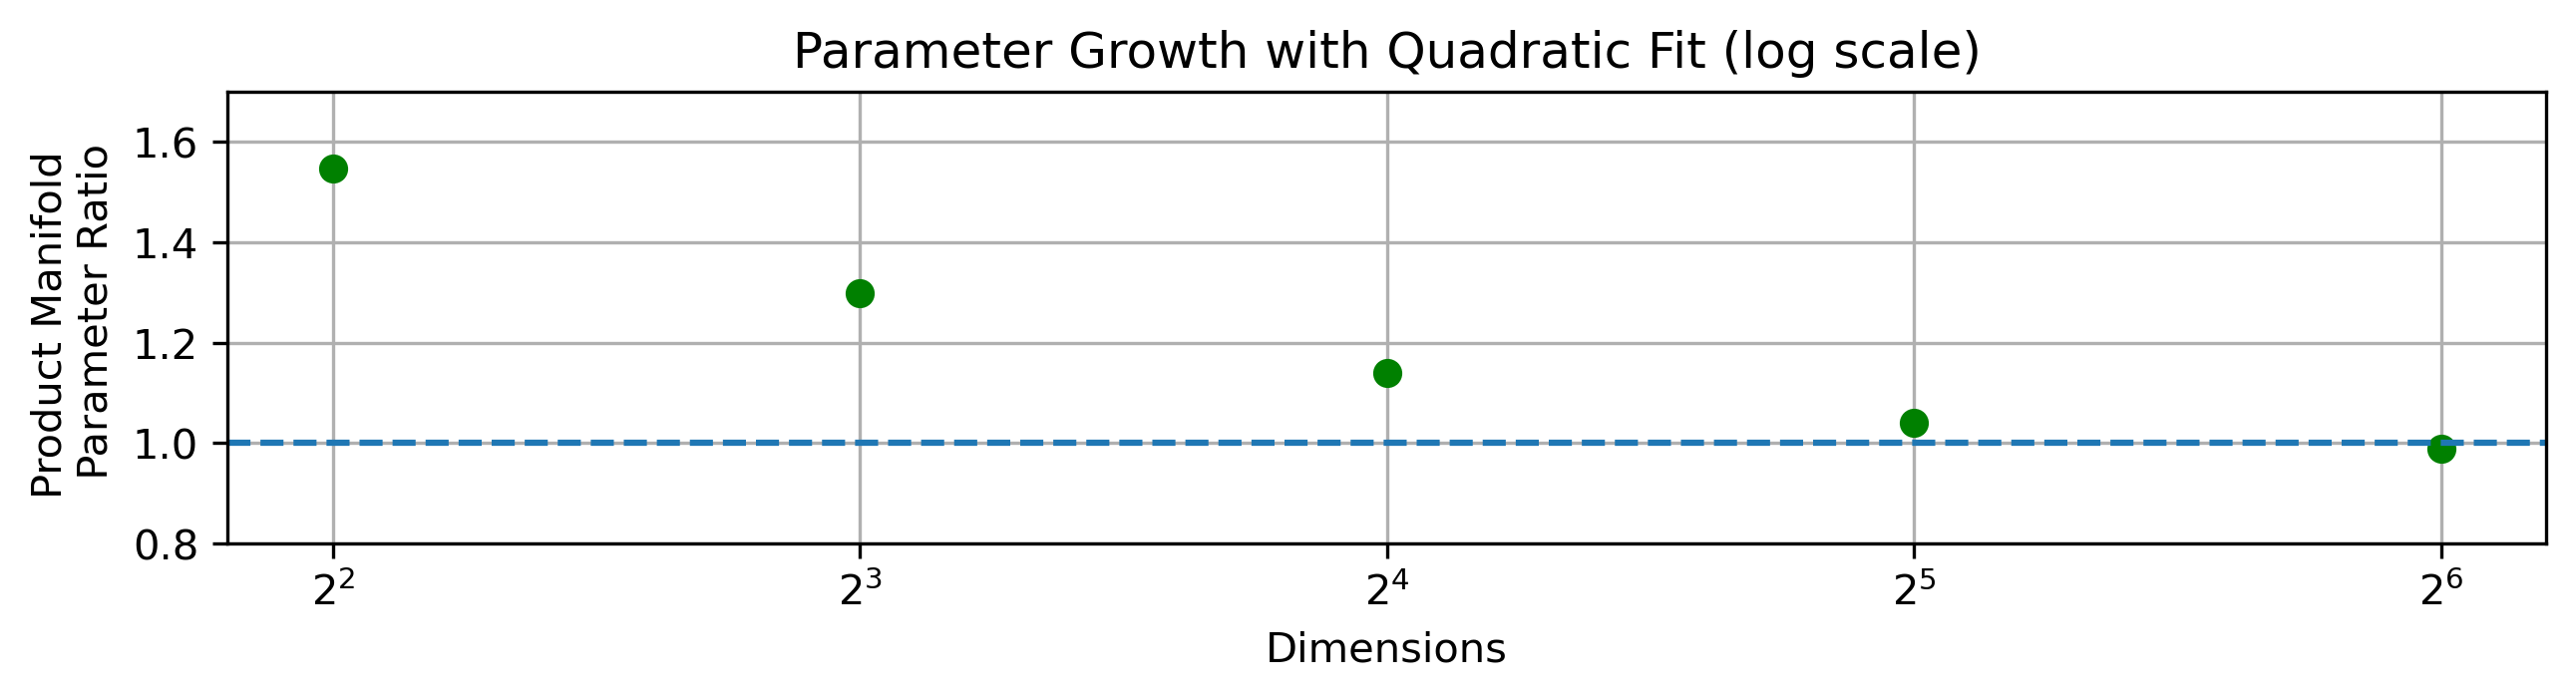

In [649]:
# total_dims = [4,8,16,32,64,128,256]
# prod_man_params = [243,357,705, 1810,5650,19860,74390]
# single_man_params = [157, 275,619, 1740, 5710,20550, 77900]

total_dims = [4,8,16,32,64]
prod_man_params = [243,357,705, 1810,5650]
single_man_params = [157, 275,619, 1740, 5710]


# Convert to log base 2 for the x-axis
log_total_dims = total_dims

# Fit quadratic models (2nd degree polynomial) for both data sets
prod_fit = np.polyfit(log_total_dims, prod_man_params, 2)
single_fit = np.polyfit(log_total_dims, single_man_params, 2)

# Generate x values for the plot up to dimension 512
x_vals = np.array([4, 8, 16, 32, 64, 128, 256, 512])

# Calculate the fitted quadratic curves
prod_quad_fit = np.polyval(prod_fit, x_vals)
single_quad_fit = np.polyval(single_fit, x_vals)

# Plotting the data and the fits
plt.figure(figsize=(10, 2),dpi = 300)
# plt.plot(log_total_dims, prod_man_params, 'o', label='Prod Manifold Params', color='blue')
plt.plot(log_total_dims, np.array(prod_man_params)/np.array(single_man_params), 'o', label='Single Manifold Params', color='green')

# # Plot the quadratic fits
# plt.plot(x_vals, prod_quad_fit, '--', label='Prod Manifold Fit', color='blue')
# plt.plot(x_vals, single_quad_fit, '--', label='Single Manifold Fit', color='green')

# Set log scale for y-axis
# plt.yscale('log',base = 10)
plt.xscale('log',base = 2)
plt.axhline(1,linestyle='--')
plt.ylim(0.8,1.7)
# plt.xlim()

# Set labels and title
plt.xlabel('Dimensions')
plt.ylabel('Product Manifold \n Parameter Ratio')
plt.title('Parameter Growth with Quadratic Fit (log scale)')

# Add legend
# plt.legend()

# Show plot
plt.grid(True)
plt.show()